[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# Normalizing flows

The image below is taken form this very good blog post on normalizing flows : [blogpost](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html)

![](https://raw.githubusercontent.com/dataflowr/website/master/modules/extras/flows/three-generative-models.png)

A **flow-based generative model** is constructed by a sequence of **invertible** transformations. The main advantage of flows is that the model explicitly learns the data distribution $p(\mathbf{x})$ and therefore the loss function is simply the negative log-likelihood.

Given a sample $\mathbf{x}$ and a prior $p(\mathbf{z})$, we compute $f(\mathbf{x}) = \mathbf{z}$ with an invertible function $f$ that will be learned. Given $f$ and the prior $p(\mathbf{z})$, we can compute the evidence $p(\mathbf{x})$ thanks to the change of variable formula:
$$
\begin{align*}
\mathbf{z} &\sim p(\mathbf{z}), \mathbf{z} = f(\mathbf{x}), \\
p(\mathbf{x}) 
&= p(\mathbf{z}) \left\vert \det \dfrac{d \mathbf{z}}{d \mathbf{x}} \right\vert  
= p(f(\mathbf{x})) \left\vert \det \dfrac{\partial f(\mathbf{x})}{\partial \mathbf{x}} \right\vert
\end{align*}
$$
where $\dfrac{\partial f(\mathbf{x})}{\partial \mathbf{x}}$ is the Jacobian matrix of $f$.
Recall that given a function mapping a $n$-dimensional input vector $\mathbf{x}$ to a $m$-dimensional output vector, $f: \mathbb{R}^n \mapsto \mathbb{R}^m$, the matrix of all first-order partial derivatives of this function is called the **Jacobian matrix**, $J_f$ where one entry on the i-th row and j-th column is $(J_f(\mathbf{x}))_{ij} = \frac{\partial f_i(\mathbf{x})}{\partial x_j}$:
$$
{J_f(\mathbf{x})} = \begin{bmatrix}
\frac{\partial f_1(\mathbf{x})}{\partial x_1} & \dots & \frac{\partial f_1(\mathbf{x})}{\partial x_n} \\[6pt]
\vdots & \ddots & \vdots \\[6pt]
\frac{\partial f_m(\mathbf{x})}{\partial x_1} & \dots & \frac{\partial f_m(\mathbf{x})}{\partial x_n} \\[6pt]
\end{bmatrix}
$$
Below, we will parametrize $f$ with a neural network and learn $f$ by maximizing $\ln p(\mathbf{x})$. More precisely, given a dataset $(\mathbf{x}_1,\dots,\mathbf{x}_n)$ and a model provided by a prior $p(\mathbf{z})$ and a neural network $f$, we optimize the weights of $f$ by minimizing:
$$
-\sum_{i}\ln p(\mathbf{x_i}) = \sum_i -\ln p(f(\mathbf{x}_i)) -\ln\left\vert \det \dfrac{\partial f(\mathbf{x}_i)}{\partial \mathbf{x}} \right\vert.
$$

**We need to ensure that $f$ is always invertible and that the determinant is simple to compute.**

## [Density estimation using Real NVP](https://arxiv.org/abs/1605.08803) 
by Laurent Dinh, Jascha Sohl-Dickstein, Samy Bengio (2016)

[Real NVP](https://arxiv.org/abs/1605.08803) uses function $f$ obtained by stacking affine coupling layers which for an input $\mathbf{x}\in \mathbb{R}^D$ produce the output $\mathbf{y}\in\mathbb{R}^D$ defined by ($d<D$): 
$$
\begin{align}

\mathbf{y}_{1:d} &= \mathbf{x}_{1:d}\\
\mathbf{y}_{d+1:D} &= \mathbf{x}_{d+1:D} \odot \exp\left(s(\mathbf{x}_{1:d})\right) +t(\mathbf{x}_{1:d}) ,
\end{align}
$$
where $s$ (scale) and $t$ (translation) are neural networks mapping $\mathbb{R}^d$ to $\mathbb{R}^{D-d}$ and $\odot$ is the element-wise product.

For any functions $s$ and $t$, the affine coupling layer is invertible:
\begin{align*}
\begin{cases}
\mathbf{y}_{1:d} &= \mathbf{x}_{1:d} \\ 
\mathbf{y}_{d+1:D} &= \mathbf{x}_{d+1:D} \odot \exp({s(\mathbf{x}_{1:d})}) + t(\mathbf{x}_{1:d})
\end{cases}
\Leftrightarrow 
\begin{cases}
\mathbf{x}_{1:d} &= \mathbf{y}_{1:d} \\ 
\mathbf{x}_{d+1:D} &= (\mathbf{y}_{d+1:D} - t(\mathbf{y}_{1:d})) \odot \exp(-s(\mathbf{y}_{1:d}))
\end{cases}
\end{align*}

The Jacobian of an affine coupling layer is a lower triangular matrix:
\begin{align*}
J(\mathbf{x}) =  \frac{\partial \mathbf{y}}{\partial \mathbf{x}}=
\begin{bmatrix}
  \mathbb{I}_d & \mathbf{0}_{d\times(D-d)} \\[5pt]
  \frac{\partial \mathbf{y}_{d+1:D}}{\partial \mathbf{x}_{1:d}} & \text{diag}(\exp(s(\mathbf{x}_{1:d})))
\end{bmatrix}
\end{align*}
Hence the determinant is simply the product of terms on the diagonal:
\begin{align*}
\left\vert\det(J(\mathbf{x}))\right\vert
= \prod_{j=1}^{D-d}\exp(s(\mathbf{x}_{1:d}))_j
= \exp\left(\sum_{j=1}^{D-d} s(\mathbf{x}_{1:d})_j\right)
\end{align*}
Note that, we do not need to compute the Jacobian of $s$ or $t$ and to compute $f^{-1}$, we do not need to compute the inverse of $s$ or $t$ (which might not exist!). In other words, we can take arbitrary complex functions for $s$ and $t$.

In one affine coupling layer, some dimensions (channels) remain unchanged. To make sure all the inputs have a chance to be altered, the model reverses the ordering in each layer so that different components are left unchanged. Following such an alternating pattern, the set of units which remain identical in one transformation layer are always modified in the next. 

This can be implemented with binary masks. First, we can extend the scale and neural networks to mappings form $\mathbb{R}^D$ to $\mathbb{R}^D$. Then taking a mask $\mathbf{b} = (1,\dots,1,0,\dots,0)$ with $d$ ones, so that we have for the affine layer:
\begin{align*}
\mathbf{y} = \mathbf{x} \odot \exp\big((1-\mathbf{b}) \odot s(\mathbf{b} \odot \mathbf{x})\big) + (1-\mathbf{b}) \odot t(\mathbf{b} \odot \mathbf{x}).
\end{align*}
Note that we have
\begin{align*}
\ln \left\vert\det(J(\mathbf{x}))\right\vert = \sum_{j=1}^{D} \Big((1-\mathbf{b})\odot s(\mathbf{b} \odot \mathbf{x})\Big)_j,
\end{align*}
and to invert the affine layer:
\begin{align*}
\mathbf{x} = \left( \mathbf{y} -(1-\mathbf{b}) \odot t(\mathbf{b} \odot \mathbf{y})\right)\odot \exp\left( -(1-\mathbf{b}) \odot s(\mathbf{b} \odot \mathbf{y})\right)
\end{align*}
Now we alternates the binary mask $\mathbf{b}$ from one coupling layer to the other. 

Note, that the formula given in the paper is sligthly different:
$$\mathbf{y} = \mathbf{b} \odot \mathbf{x} + (1 - \mathbf{b}) \odot \Big(\mathbf{x} \odot \exp\big(s(\mathbf{b} \odot \mathbf{x})\big) + t(\mathbf{b} \odot \mathbf{x})\Big),$$
but the 2 formulas give the same result!

# Implementation of Real NVP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 5, 4
rcParams['figure.dpi'] = 150

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import datasets

In [2]:
nets = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
# functions that take no arguments and return a pytorch model, dim(X) -> dim(X)

masks = torch.from_numpy(np.array([[0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0]]).astype(np.float32))
# torch.Tensor of size number_of_coupling_layers x dim(X)

In [3]:
masks.shape

torch.Size([6, 2])

In [4]:
from torch import distributions
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

In [6]:
# you can compute logprob and sample from your distribution:
print(prior.log_prob(torch.Tensor([0, 0])))
print(prior.sample((3,)))

tensor(-1.8379)
tensor([[-0.2295, -0.1030],
        [-0.8183, -1.0620],
        [ 0.1732,  0.1720]])


In [104]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, masks, prior):
        super(RealNVP, self).__init__()
        
        # Create a flow
        # nets:  a function that returns a PyTorch neural network, e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that returns a PyTorch neural network, e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal
        
        self.prior = prior
        self.masks = nn.Parameter(masks, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        

    def f(self, x):        
        # Compute f(x) = z and log_det_Jakobian of f, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        z, log_det_J = x, x.new_zeros(x.shape[0])
        for i in range(len(self.t)):
            mask = self.masks[i]
            # z_masked this is the x_{1:d} in the blog
            z_ = z * mask
            # (1-mask) is to limit to {d+1:D}
            s = self.s[i](z_) * (1-mask)
            t = self.t[i](z_) * (1-mask)
            
            # follow the blog
            z = z * torch.exp(s) + t
            
            # sum of diagonal of the jacob matrix under RealNVP settings
            # the det in RealNVP is exp(sum(s))
            # then log_det cancels the exp()
            log_det_J += s.sum(dim=1)

            # What's the difference between torch.sum() and tensor.sum()?
        
        return z, log_det_J
    
    def g(self, z):
        # Compute and return g(z) = x, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # z: a torch.Tensor of shape batchSize x dim(X)
        # return x: a torch.Tensor of shape batchSize x dim(X)
        x = z
        #for i in range(self.len-1, -1, -1):
        for i in reversed(range(len(self.t))):
            mask = self.masks[i]
            x_ = x * mask
            s = self.s[i](x_) * (1-mask)
            t = self.t[i](x_) * (1-mask)

            x = (x - t) * torch.exp(-s)
        return x
    
    def log_prob(self, x):
        # Compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        
        # get f(x) and sum of log dets
        z, logdets = self.f(x)
        # the logdets over here is the forward one
        # loss is the minus of this

        logp = self.prior.log_prob(z)
        # here follows -sum(log(p(x_i))) = -sum(log(p(f(x_i)))) - log(det(Jf(x_i)))
        # more details see 
        # https://medium.com/@sthanikamsanthosh1994/flow-based-models-for-data-generation-normalizing-flows-f6db41ac513a
        # and the paper "Normalizing Flows: An Introduction and Review of Current Methods"
        return logp + logdets
        
    def sample(self, batchSize): 
        # Draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x dim(X)
        z = self.prior.sample((batchSize,))
        x = self.g(z)
        return x

In [115]:
flow = RealNVP(nets, nett, masks, prior)

In [108]:
# Check that a flow is invertible g(f(x)) = x Hint: torch.allclose
x = prior.sample([1,])
display(x)
(z, _) = flow.f(x)
display(z)
xx = flow.g(z)
display(xx)

display(torch.allclose(x, xx))

tensor([[ 0.0394, -0.8651]])

tensor([[ 0.3611, -0.6959]], grad_fn=<AddBackward0>)

tensor([[ 0.0394, -0.8651]], grad_fn=<MulBackward0>)

True

In [110]:
s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
s

ModuleList(
  (0-5): 6 x Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=2, bias=True)
    (5): Tanh()
  )
)

In [111]:
z = datasets.make_moons(n_samples=1, noise=.05)[0].astype(np.float32) 
z

array([[-0.01790809,  0.40579638]], dtype=float32)

In [112]:
display(flow.log_prob(prior.sample((2,))))
display(flow.log_prob(torch.from_numpy(z)))

tensor([-3.6588, -2.3439], grad_fn=<AddBackward0>)

tensor([-2.2078], grad_fn=<AddBackward0>)

In [116]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4) # choose an optimizer, use module torch.optim
# if choose lr = 1e-2 is just not works somehow

for t in range(5001):    
    noisy_moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
    loss = -flow.log_prob(torch.from_numpy(noisy_moons)).mean() # compute the maximum-likelihood loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
# Check that the loss decreases
# Is the visualization below good?

iter 0: loss = 2.618
iter 500: loss = 0.571
iter 1000: loss = 0.450
iter 1500: loss = 0.504
iter 2000: loss = 0.415
iter 2500: loss = 0.305
iter 3000: loss = 0.495
iter 3500: loss = 0.467
iter 4000: loss = 0.580
iter 4500: loss = 0.479
iter 5000: loss = 0.368


In [117]:
import pickle, os
if not os.path.isfile("model_flow.sav"):
    file = open("model_flow.sav",'wb')
    pickle.dump(flow, file)

# Visualization

In [118]:
rcParams['figure.figsize'] = 10, 8

Draw several plots: 
- samples from flow
- samples from prior
- data samples
- mapping form data to prior

Text(0.5, 1.0, '$X = g(z)$')

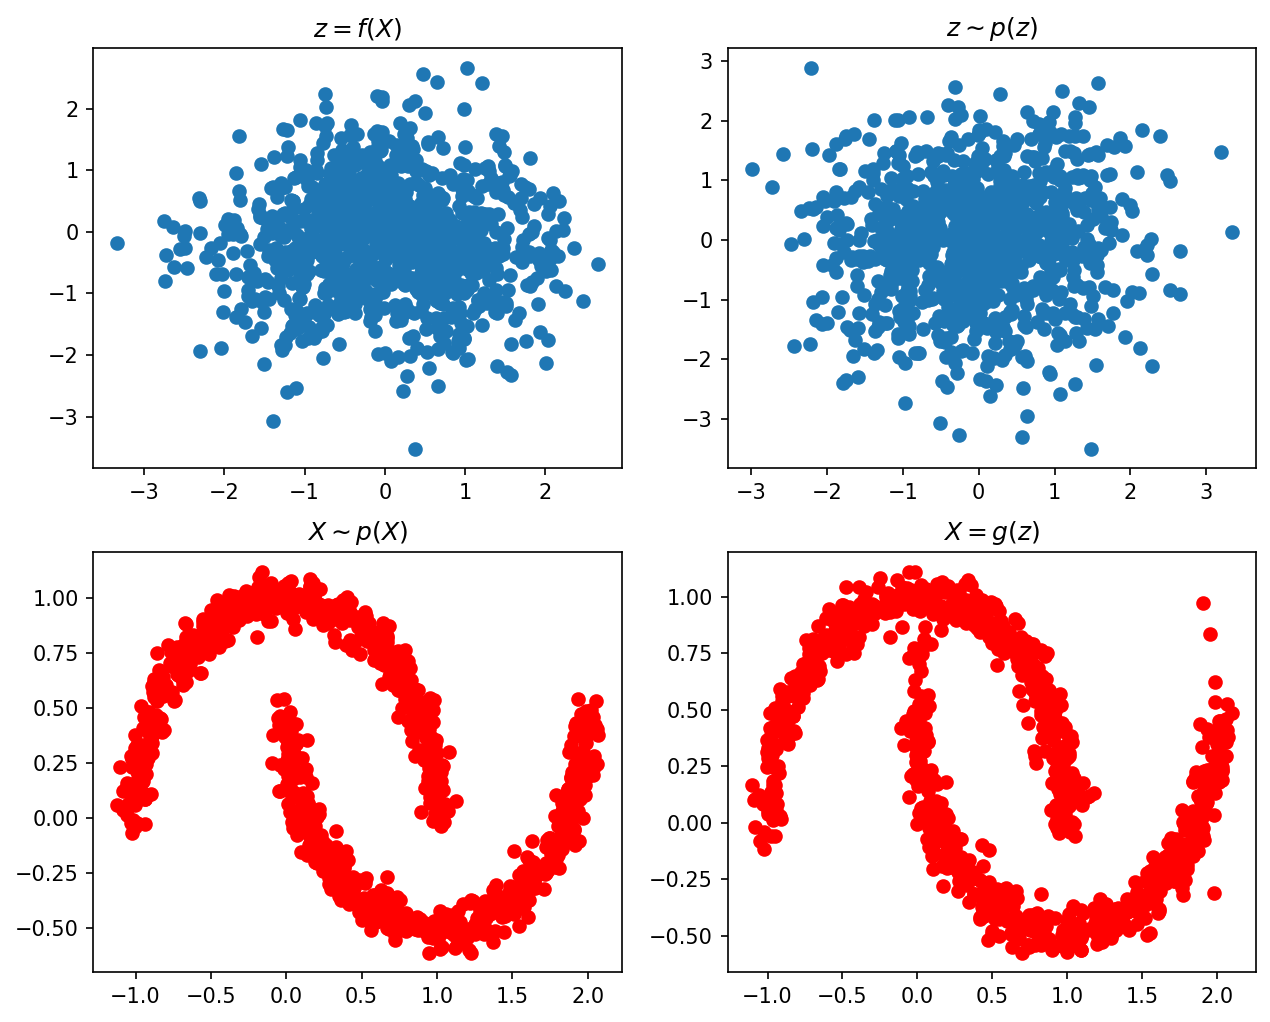

In [119]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X = g(z)$')

Draw the estimated density:

In [120]:
xpoints = np.linspace(-1.5, 2.5, 500)
ypoints = np.linspace(-1.0, 1.5, 500)
(x1, x2,) = np.meshgrid(xpoints, ypoints)
xgrid = np.concatenate((x1.reshape(-1, 1), x2.reshape(-1, 1)), axis=1).astype(np.float32)
p = np.exp(flow.log_prob(torch.from_numpy(xgrid)).detach().numpy())

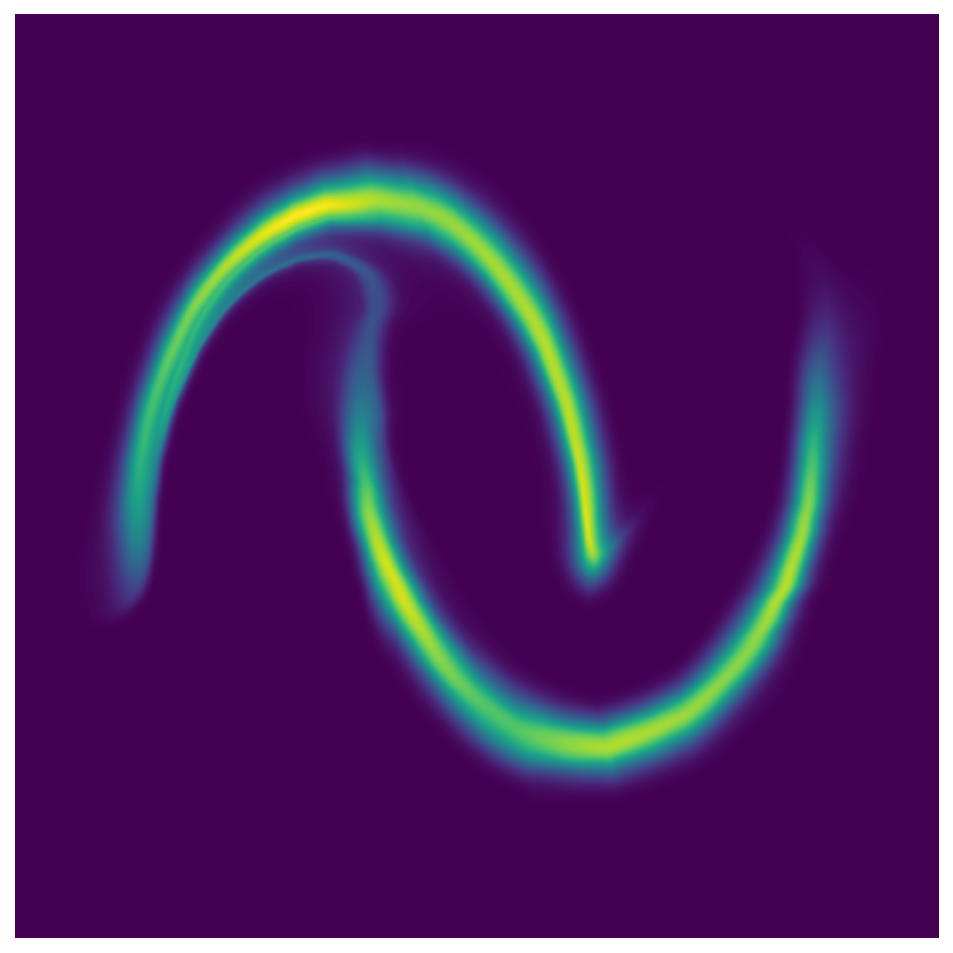

In [121]:
fig = plt.figure()
plt.imshow(
    p.reshape(x1.shape), aspect="equal", origin="lower")
plt.axis('off')
plt.show()

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)